## E15 - 단어 수준의 번역기 만들기

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 178009


,eng,fra,cc
36745,I'm sorry about this.,J'en suis désolée.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
109106,Do not give in to those demands.,Ne cède pas à ces exigences.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
149153,I left work early and went straight home.,J'ai quitté mon travail tôt et suis rentré dir...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
25977,She was all smiles.,Elle était tout sourire.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
72483,The water is really dirty.,L'eau est très sale.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [2]:
lines = lines[['eng', 'fra']][20000:53000] # 3만3천개의 샘플 사용, 세 번째 열은 제외
lines.sample(5)

,eng,fra
23026,Birds are chirping.,Les oiseaux chantent.
22907,Are they satisfied?,Sont-ils contentés ?
24499,I love fairy tales.,J'adore les contes de fées.
52772,You are not our friend.,Tu n'es pas notre amie.
40423,Did you all know that?,Est-ce que vous connaissiez tous ça ?


In [3]:
# 전처리 함수 구현
import re
import unicodedata

# 시작 토큰과 종료 토큰 추가
sos_token = '<start> '
eos_token = ' <end>'

def preprocess(cols, sentence):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,¿,'-])", r" \1 ", sentence)
    sentence = re.sub(r"\s+", r" ", sentence)
    sentence = sentence.strip()
    
    if cols == 'fra':
        sentence = sos_token + sentence + eos_token
            
    return sentence

In [4]:
lines.eng = lines.eng.apply(lambda x: preprocess('eng', x))
lines.fra = lines.fra.apply(lambda x: preprocess('fra', x))
print('전체 샘플의 수 :',len(lines))
lines.sample(10)

전체 샘플의 수 : 33000


,eng,fra
21322,they will survive .,<start> elles survivront . <end>
22115,what happens next ?,<start> que se passe - t - il ensuite ? <end>
25907,she invited him in .,<start> elle lui demanda de bien vouloir entre...
35675,i kept an eye on tom .,<start> j ' ai gardé un œil sur tom . <end>
34075,did you just hit tom ?,<start> est - ce que tu viens juste de taper t...
35549,i had nothing to say .,<start> je n ' avais rien à dire . <end>
45699,what is the cat up to ?,<start> qu ' est - ce que le chat manigance ? ...
24346,i have two cousins .,<start> j ' ai deux cousines . <end>
30776,is this permissible ?,<start> est - ce autorisé ? <end>
42352,i need you to go home .,<start> j ' ai besoin que vous alliez à la mai...


In [5]:
# 단어장을 만들기, 영어와 프랑스어별로

def tokenize(corpus):
    tokenizer = Tokenizer(filters=' ')            # 단어 단위로 Tokenizer를 생성합니다.
    tokenizer.fit_on_texts(corpus)                # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
    tensor = tokenizer.texts_to_sequences(corpus) # 단어를 숫자값 인덱스로 변환하여 저장

    return tensor, tokenizer

In [6]:
input_text, eng_tokenizer = tokenize(lines.eng)
input_text[:3]

[[3, 2, 22, 70, 30, 174, 1],
 [3, 2, 22, 70, 30, 174, 1],
 [3, 2, 22, 70, 509, 1]]

In [7]:
target_text, fra_tokenizer = tokenize(lines.fra)
target_text[:3]

[[1, 6, 20, 4, 29, 31, 202, 10, 318, 3, 2],
 [1, 6, 20, 4, 29, 31, 202, 10, 634, 3, 2],
 [1, 6, 13, 130, 21, 436, 3, 2]]

In [8]:
# eng = lines.eng.apply(lambda x: x.split())
# eng_tokenizer = Tokenizer()                          
# eng_tokenizer.fit_on_texts(eng) 
# input_text = eng_tokenizer.texts_to_sequences(eng)    
# input_text[:3]
# # print(eng_tokenizer.word_index) 각 단어의 인덱스 확인하는 함수

In [9]:
# fra = lines.fra.apply(lambda x: x.split())
# fra_tokenizer = Tokenizer()                         # 단어 단위로 Tokenizer를 생성합니다. 
# fra_tokenizer.fit_on_texts(fra)                     # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
# target_text = fra_tokenizer.texts_to_sequences(fra) # 단어를 숫자값 인덱스로 변환하여 저장
# target_text[:3]

In [10]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 5211
프랑스어 단어장의 크기 : 9021


In [11]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)
# 패딩처리하기 위해

영어 시퀀스의 최대 길이 11
프랑스어 시퀀스의 최대 길이 20


In [12]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 5211
프랑스어 단어장의 크기 : 9021
영어 시퀀스의 최대 길이 11
프랑스어 시퀀스의 최대 길이 20


In [13]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [x[:-1] for x in target_text]
# 시작 토큰 제거
decoder_target = [x[1:] for x in target_text]

In [14]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 6, 20, 4, 29, 31, 202, 10, 318, 3], [1, 6, 20, 4, 29, 31, 202, 10, 634, 3], [1, 6, 13, 130, 21, 436, 3]]
[[6, 20, 4, 29, 31, 202, 10, 318, 3, 2], [6, 20, 4, 29, 31, 202, 10, 634, 3, 2], [6, 13, 130, 21, 436, 3, 2]]


In [15]:
# for sent in decoder_target:
#     print(' '.join(list(map(lambda x: fra_tokenizer.index_word[x], sent))))

In [16]:
# 패딩 처리하기
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 11)
프랑스어 입력데이터의 크기(shape) : (33000, 20)
프랑스어 출력데이터의 크기(shape) : (33000, 20)


In [17]:
# 학습데이터와 검증데이터 분리하기

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 11)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 20)


In [18]:
from tensorflow.keras.layers import Input, Embedding, Masking, Dense, LSTM
from tensorflow.keras.models import Model

embedding_size = 1024
hidden_size = 512

# 인코더 설계
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, embedding_size)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

# 디코더 설계
decoder_inputs = Input(shape=(None,))
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 출력층
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [19]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 1024)   5336064     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1024)   9237504     input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, epochs=30)

Epoch 1/30
118/118 [==============================] - 19s 161ms/step - loss: 1.9555 - val_loss: 1.6680
Epoch 2/30
118/118 [==============================] - 19s 159ms/step - loss: 1.2888 - val_loss: 1.3897
Epoch 3/30
118/118 [==============================] - 20s 166ms/step - loss: 1.0748 - val_loss: 1.2305
Epoch 4/30
118/118 [==============================] - 20s 166ms/step - loss: 0.9392 - val_loss: 1.1612
Epoch 5/30
118/118 [==============================] - 20s 167ms/step - loss: 0.8327 - val_loss: 1.0856
Epoch 6/30
118/118 [==============================] - 19s 161ms/step - loss: 0.7439 - val_loss: 1.0503
Epoch 7/30
118/118 [==============================] - 18s 152ms/step - loss: 0.6657 - val_loss: 0.9957
Epoch 8/30
118/118 [==============================] - 18s 152ms/step - loss: 0.5948 - val_loss: 0.9674
Epoch 9/30
118/118 [==============================] - 18s 153ms/step - loss: 0.5322 - val_loss: 0.9501
Epoch 10/30
118/118 [==============================] - 18s 151ms/step - l

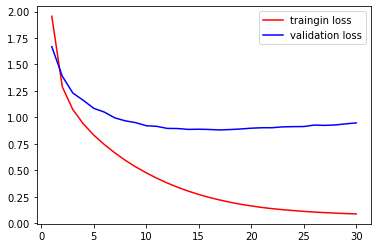

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='traingin loss', color='red')
plt.plot(epochs, val_loss, 'b', label='validation loss', color='blue')
plt.legend()
plt.show()

In [22]:
# 테스트하기

# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 1024)        5336064   
_________________________________________________________________
masking (Masking)            (None, None, 1024)        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 3147776   
Total params: 8,483,840
Trainable params: 8,483,840
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 디코더 정의

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states2 = [state_h2, state_c2]

# 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1024)   9237504     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [24]:
# 정수->단어, 단어->정수

eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [25]:
# decode_sequence(): 입력 인자는 번역하고자 하는 문장의 정수 시퀀스

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence[1:]

In [26]:
import random as rd
sel_lst = [rd.randint(1, 30000) for _ in range(5)]

for seq_index in sel_lst:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index + 20000])
    print('정답 문장:', lines.fra[seq_index + 20000][8:-6])
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: he owns a lot of land .
정답 문장: il possède beaucoup de terre .
번역기가 번역한 문장: il beaucoup un un d
-----------------------------------
입력 문장: they seem surprised .
정답 문장: ils semblent surpris .
번역기가 번역한 문장: elles l l l les de d
-----------------------------------
입력 문장: don ' t spoil your child .
정답 문장: ne gâtez pas votre enfant .
번역기가 번역한 문장: ne ne ne de ici ! ! 
-----------------------------------
입력 문장: you lack imagination .
정답 문장: vous manquez d ' imagination .
번역기가 번역한 문장: tu vous - . . . . . 
-----------------------------------
입력 문장: she taught us singing .
정답 문장: elle nous enseigna à chanter .
번역기가 번역한 문장: elle nous nous nous nou
